# Bayesian Exploration
Here we demonstrate the use of Bayesian Exploration to characterize an unknown
function in the presence of constraints (see [here](https://www.nature.com/articles/s41467-021-25757-3)).
The function we wish to explore is the first objective of the TNK test problem.

## Specifiying generator options
We start with the generator defaults and modify as needed for conservative
exploration, which should prevent any constraint violations.

In [1]:
import pandas as pd
import torch
import yaml
from copy import deepcopy
from xopt import Xopt, Evaluator
from xopt.generators.bayesian import BayesianExplorationGenerator
from xopt.resources.test_functions.tnk import evaluate_TNK, tnk_vocs

vocs = deepcopy(tnk_vocs)

# can only explore one objectiv
del vocs.objectives["y2"]

generator_options = BayesianExplorationGenerator.default_options()
generator_options.optim.num_restarts = 1
generator_options.optim.raw_samples = 100
generator_options.model.use_conservative_prior_mean = True
generator_options.model.use_conservative_prior_lengthscale = True
generator_options.model.use_low_noise_prior = True
generator_options.acq.proximal_lengthscales = [1.5, 1.5]

evaluator = Evaluator(function=evaluate_TNK)
generator = BayesianExplorationGenerator(vocs, generator_options)

print(yaml.dump(generator.options.dict()))

acq:
  monte_carlo_samples: 512
  proximal_lengthscales:
  - 1.5
  - 1.5
model:
  use_conservative_prior_lengthscale: true
  use_conservative_prior_mean: true
  use_low_noise_prior: true
n_initial: 3
optim:
  num_restarts: 1
  raw_samples: 100
  sequential: true



## Run exploration
We start with evaluating 2 points that we know satisfy the constraints. We then run
30 exploration steps.

In [2]:
X = Xopt(generator=generator, evaluator=evaluator, vocs=vocs)
X.submit_data(pd.DataFrame({"x1":[1.0, 0.75],"x2":[0.75, 1.0]}))

for i in range(10):
    print(f"step {i}")
    X.step()

step 0


/usr/share/miniconda/envs/xopt-dev/lib/python3.9/site-packages/gpytorch/lazy/lazy_tensor.py:1810: UserWarning: torch.triangular_solve is deprecated in favor of torch.linalg.solve_triangularand will be removed in a future PyTorch release.
torch.linalg.solve_triangular has its arguments reversed and does not return a copy of one of the inputs.
X = torch.triangular_solve(B, A).solution
should be replaced with
X = torch.linalg.solve_triangular(A, B). (Triggered internally at  /home/conda/feedstock_root/build_artifacts/pytorch-recipe_1654951030282/work/aten/src/ATen/native/BatchLinearAlgebra.cpp:1666.)
  Linv = torch.triangular_solve(Eye, L, upper=False).solution


step 1
step 2
step 3
step 4
step 5
step 6
step 7
step 8
step 9


In [3]:
# view the data
X.data

,x1,x2,y1,y2,c1,c2,some_array,xopt_error,xopt_error_str,a
1,1.000000,0.750000,1.000000,0.750000,0.626888,0.312500,"[1, 2, 3]",False,,NaN
2,0.750000,1.000000,0.750000,1.000000,0.626888,0.312500,"[1, 2, 3]",False,,NaN
3,0.782777,0.791094,0.782777,0.791094,0.138927,0.164699,"[1, 2, 3]",False,,dummy_constant
4,0.877066,0.865192,0.877066,0.865192,0.418395,0.275544,"[1, 2, 3]",False,,dummy_constant
5,0.662383,0.926818,0.662383,0.926818,0.385336,0.208542,"[1, 2, 3]",False,,dummy_constant
6,0.723612,0.885769,0.723612,0.885769,0.311789,0.198820,"[1, 2, 3]",False,,dummy_constant
7,1.047846,0.801104,1.047846,0.801104,0.792176,0.390799,"[1, 2, 3]",False,,dummy_constant
8,0.942570,0.716150,0.942570,0.716150,0.457760,0.242589,"[1, 2, 3]",False,,dummy_constant
9,0.584621,0.954039,0.584621,0.954039,0.332863,0.213312,"[1, 2, 3]",False,,dummy_constant
10,0.540165,1.015531,0.540165,1.015531,0.319835,0.267386,"[1, 2, 3]",False,,dummy_constant


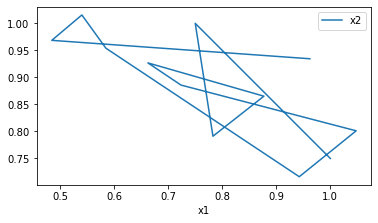

In [4]:
# plot results
ax = X.data.plot("x1", "x2")
ax.set_aspect("equal")

## Introspect models
During exploration we generate Gaussian Process models of each objective and
constraint. We demonstrate how they are viewed below.

/usr/share/miniconda/envs/xopt-dev/lib/python3.9/site-packages/torch/functional.py:568: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /home/conda/feedstock_root/build_artifacts/pytorch-recipe_1654951030282/work/aten/src/ATen/native/TensorShape.cpp:2227.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


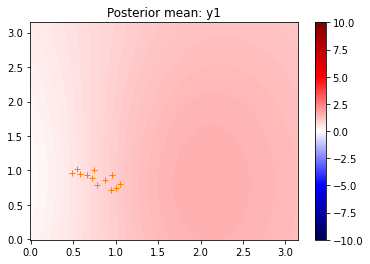

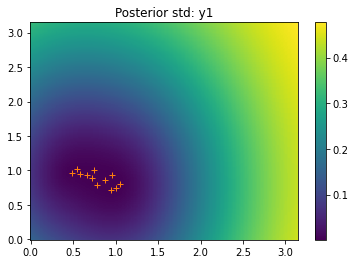

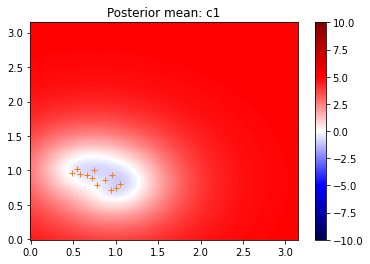

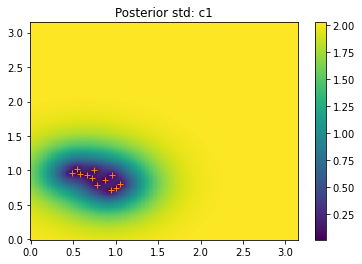

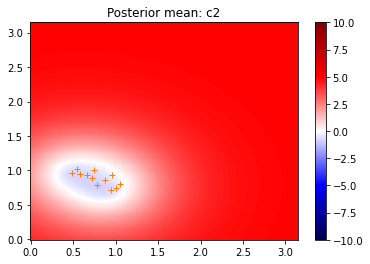

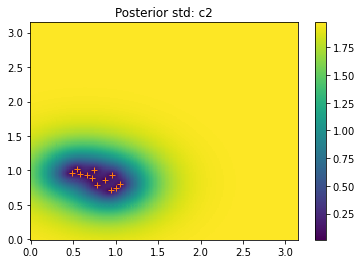

In [5]:
from matplotlib import pyplot as plt  # plot model predictions

data = X.data

bounds = generator.vocs.bounds
model = generator.train_model(generator.data)

# create mesh
n = 200
x = torch.linspace(*bounds.T[0], n)
y = torch.linspace(*bounds.T[1], n)
xx, yy = torch.meshgrid(x, y)
pts = torch.hstack([ele.reshape(-1, 1) for ele in (xx, yy)]).double()

outputs = generator.vocs.output_names
with torch.no_grad():
    post = model.posterior(pts)

    mean = post.mean
    std = torch.sqrt(post.variance)

    for i in range(mean.shape[-1]):
        fig, ax = plt.subplots()
        ax.plot(*data[["x1", "x2"]].to_numpy().T, "+C1")
        c = ax.pcolor(xx, yy, mean[:, i].reshape(n, n), cmap="seismic",vmin=-10.0,
                      vmax=10.0)
        fig.colorbar(c)
        ax.set_title(f"Posterior mean: {outputs[i]}")

        fig2, ax2 = plt.subplots()
        ax2.plot(*data[["x1", "x2"]].to_numpy().T, "+C1")
        c = ax2.pcolor(xx, yy, std[:, i].reshape(n, n))
        fig2.colorbar(c)
        ax2.set_title(f"Posterior std: {outputs[i]}")

## View acquisition function and feasibility prediction

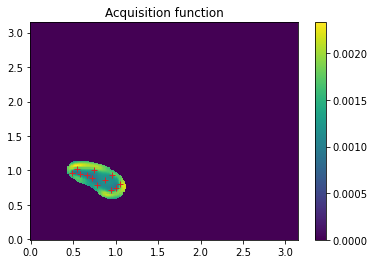

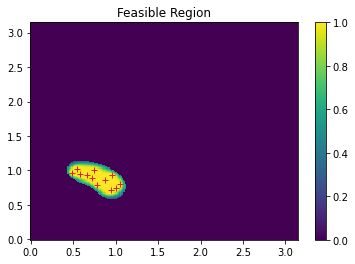

In [6]:
from xopt.generators.bayesian.utils import feasibility

acq_func = generator.get_acquisition(model)
with torch.no_grad():
    acq_pts = pts.unsqueeze(1)
    acq = acq_func(acq_pts)

    fig, ax = plt.subplots()
    c = ax.pcolor(xx, yy, acq.reshape(n, n))
    ax.plot(*data[["x1", "x2"]].to_numpy().T, "+C3")

    fig.colorbar(c)
    ax.set_title("Acquisition function")

    feas = feasibility(pts.unsqueeze(1), model, generator.sampler, vocs).flatten()

    fig2, ax2 = plt.subplots()
    c = ax2.pcolor(xx, yy, feas.reshape(n, n))
    ax2.plot(*data[["x1", "x2"]].to_numpy().T, "+C3")

    fig2.colorbar(c)
    ax2.set_title("Feasible Region")

## Generator model hyperparameters

In [7]:
# print generator model hyperparameters
for name, val in X.generator.model.named_parameters():
    print(f"{name}:{val}")

X.generator.model.models[2].covar_module.base_kernel.lengthscale

models.0.likelihood.noise_covar.raw_noise:Parameter containing:
tensor([-26.8902], dtype=torch.float64, requires_grad=True)
models.0.mean_module.constant:Parameter containing:
tensor([-0.1440], dtype=torch.float64, requires_grad=True)
models.0.covar_module.raw_outputscale:7.877995419945529
models.0.covar_module.base_kernel.raw_lengthscale:Parameter containing:
tensor([[-0.3152,  0.3700]], dtype=torch.float64, requires_grad=True)
models.1.likelihood.noise_covar.raw_noise:Parameter containing:
tensor([-18.8822], dtype=torch.float64, requires_grad=True)
models.1.mean_module.constant:5.0
models.1.covar_module.raw_outputscale:4.099695733441843
models.1.covar_module.base_kernel.raw_lengthscale:Parameter containing:
tensor([[-1.6700, -1.8401]], dtype=torch.float64, requires_grad=True)
models.2.likelihood.noise_covar.raw_noise:Parameter containing:
tensor([-21.2603], dtype=torch.float64, requires_grad=True)
models.2.mean_module.constant:5.0
models.2.covar_module.raw_outputscale:3.8815117536594

tensor([[0.1781, 0.1510]], dtype=torch.float64, grad_fn=<SoftplusBackward0>)

## Examine the number of constraint violations
Using the convience function provided by the vocs object we can evaluate which
samples violate either or both of our constraints.

In [8]:
X.vocs.feasibility_data(X.data)

,feasible_c1,feasible_c2,feasible
1,True,True,True
2,True,True,True
3,True,True,True
4,True,True,True
5,True,True,True
6,True,True,True
7,True,True,True
8,True,True,True
9,True,True,True
10,True,True,True
